### Matching CPS observations over time

##### Example with flow from disability to work

---

May 19, 2018

Brian Dew, @bd_econ

---

Example uses CPS microdata that has already been cleaned and saved as feather format files, to calculate what percent of people age 25 to 54 who were not working the year before due to disability but are employed in the current month. 

In [14]:
# Import packages and set preliminaries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
mpl.rc('figure', figsize=[9, 4])
plt.rc('axes', axisbelow=True)

#tloc = 'C:/Working/Dropbox (CEPR)/homestata/Brian/SP02-College_Returns/data'

In [28]:
# Calculate disabled to work flow
data = pd.DataFrame()

# For each year calculate change over year before
for year in list(range(1995, 2019)):

    # Load year one
    df1 = pd.read_feather(f'data/cps_{year-1}.ft', nthreads=3)

    # Filter row-wise
    df1 = df1[(df1['PRTAGE'].between(25, 54)) &
              (df1['HRMIS'] < 5)]

    # Generate flow1 variable
    df1['flow1'] = np.where((df1['PEMLR'].isin([1,2])), 1, 0)

    # Generate unique ID
    df1['UID'] = (df1['GESTFIPS'].astype(str) + 
                  df1['HRHHID'].astype(str) + 
                  df1['HRHHID2'].astype(str) + 
                  df1['PULINENO'].astype(str))

    # Fix year if needed
    if 'HRYEAR' in df1.keys():
        df1['HRYEAR4'] = df1['HRYEAR'] + 1900

    # Filter column-wise
    df1 = df1[['UID','HRMONTH','HRYEAR4','HRMIS','PRTAGE','flow1', 
               'PWSSWGT','PESEX','PRDTRACE','GESTFIPS']]

    # Load year two
    df2 = pd.read_feather(f'data/cps_{year}.ft', nthreads=3)

    # Filter row-wise
    df2 = df2[(df2['PRTAGE'].between(25, 54)) &
              (df2['HRMIS'] > 4)]

    # Generate flow2 variable
    df2['flow2'] = np.where((df2['PEMLR'].isin([3])), 1, 0)

    # Generate unique ID
    df2['UID'] = (df2['GESTFIPS'].astype(str) + 
                  df2['HRHHID'].astype(str) + 
                  df2['HRHHID2'].astype(str) + 
                  df2['PULINENO'].astype(str))

    # Fix year if needed
    if 'HRYEAR' in df2.keys():
        df2['HRYEAR4'] = df2['HRYEAR'] + 1900

    # Filter column-wise
    df2 = df2[['UID','HRMONTH','HRYEAR4','HRMIS','PRTAGE','flow2', 
               'PWSSWGT','PESEX','PRDTRACE','GESTFIPS']]

    # List of months to loop over 
    mos = list(range(1, max(df2['HRMONTH']) + 1))

    # Loop over the months
    for mo in mos:

        # Generate merge groups
        g1 = df1[(df1['HRMONTH'] == mo) & (df1['HRMIS'] == 1)]
        g5 = df2[(df2['HRMONTH'] == mo) & (df2['HRMIS'] == 5)]
        g2 = df1[(df1['HRMONTH'] == mo) & (df1['HRMIS'] == 2)]
        g6 = df2[(df2['HRMONTH'] == mo) & (df2['HRMIS'] == 6)]
        g3 = df1[(df1['HRMONTH'] == mo) & (df1['HRMIS'] == 3)]
        g7 = df2[(df2['HRMONTH'] == mo) & (df2['HRMIS'] == 7)]
        g4 = df1[(df1['HRMONTH'] == mo) & (df1['HRMIS'] == 4)]
        g8 = df2[(df2['HRMONTH'] == mo) & (df2['HRMIS'] == 8)]    

        # Naive merge
        naive = (pd.merge(g1, g5, on='UID', how='inner').append(
                 pd.merge(g2, g6, on='UID', how='inner')).append(
                 pd.merge(g3, g7, on='UID', how='inner')).append(
                 pd.merge(g4, g8, on='UID', how='inner')))    

        # Filter by SRA
        mdata = naive[(naive['PESEX_x'] == naive['PESEX_y']) &
                      (naive['PRDTRACE_x'] == naive['PRDTRACE_y']) &
                      (naive['PRTAGE_x'] <= naive['PRTAGE_y'] + 2) &
                      (naive['PRTAGE_y'] >= naive['PRTAGE_x'])]   

        # Calculate outflow
        of = mdata[(mdata['flow1']==1) & (mdata['flow2']==1)]['PWSSWGT_y'].sum()

        # Calculate total
        tot = mdata[(mdata['flow1']==1)]['PWSSWGT_y'].sum()

        # Print share
        data.at[pd.to_datetime(f'{year}-{mo}-01'), 'Share'] = (of/tot) * 100

C:\Users\BDew\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in longlong_scalars


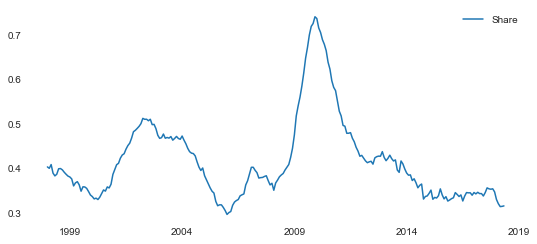

In [34]:
data.rolling(12).mean().loc['1998':].plot()

In [35]:
df = pd.read_feather('data/cps_1998.ft', nthreads=3)

In [36]:
df[(df['PRTAGE'] >= 50) & ((df['PEIO1COW']==7) | (df['PEIO2COW']==7))]

,HRHHID,HRMONTH,HRYEAR4,HRMIS,GESTFIPS,GTMETSTA,PRTAGE,PESEX,PEEDUCA,PRDTRACE,...,PRERNWA,PEERNLAB,PENLFRET,PENLFACT,PWLGWGT,PWORWGT,PWSSWGT,PWCMPWGT,WBHAO,HRHHID2
15,961459530229005,4,1998,3,1,1,71,2,38,1,...,-1,-1,-1,-1,37898933,0,27066529,27834649,1,69001
100,800109905887199,4,1998,6,1,1,61,1,40,1,...,-1,-1,-1,-1,28859574,0,20518643,20948694,1,67001
220,343099839100940,4,1998,2,1,1,73,1,40,1,...,-1,-1,-1,-1,28336159,0,20146504,20243692,1,69001
239,308907920991161,4,1998,6,1,1,55,1,43,1,...,-1,-1,-1,-1,30757662,0,21868150,22317168,1,67001
257,655081961019890,4,1998,5,1,1,58,1,39,1,...,-1,-1,-1,-1,0,0,29528259,30134562,1,68001
287,52130510013004,4,1998,1,1,1,52,2,39,1,...,-1,-1,-1,-1,0,0,23542030,24538517,1,69001
300,4430811691694,4,1998,6,1,1,50,1,40,1,...,-1,-1,-1,-1,32301543,0,22965822,23669380,1,67001
347,350716091501609,4,1998,5,1,1,66,1,40,1,...,-1,-1,-1,-1,0,0,28351199,29269694,1,68001
487,508901700799471,4,1998,6,1,1,50,1,39,1,...,-1,-1,-1,-1,32301543,0,22965822,23669380,1,67001
541,871259160489001,4,1998,8,1,1,61,2,39,1,...,33600,2,-1,-1,36944938,102344856,26385208,26890432,1,67001


In [25]:
pd.read_feather('data/cps_2017.ft', nthreads=3).groupby(['PRSJMJ'])['PWSSWGT'].sum()[2]

908098665188.0

In [27]:
908098665188 / (17576707619436 + 908098665188)

0.04912676125491091